In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-12-06 13:10:48--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.38.214, 52.217.67.30, 52.216.98.21, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.38.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  6.49MB/s    in 2.0s    

2022-12-06 13:10:51 (6.49 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

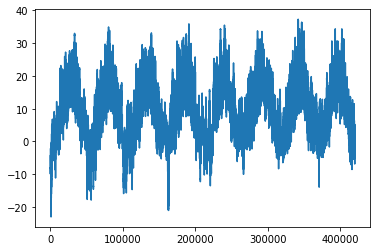

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

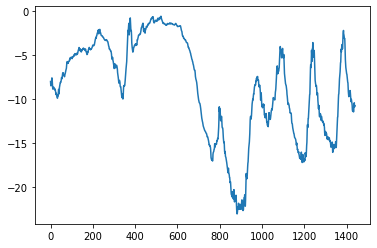

In [5]:
plt.plot(range(1440), temperature[:1440])

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 53s 64ms/step - loss: 12.4943 - mae: 2.7463 - val_loss: 16.0789 - val_mae: 3.1933
Epoch 2/10
819/819 [==============================] - 53s 65ms/step - loss: 8.9577 - mae: 2.3531 - val_loss: 10.0900 - val_mae: 2.5070
Epoch 3/10
819/819 [==============================] - 47s 57ms/step - loss: 8.1997 - mae: 2.2525 - val_loss: 9.9286 - val_mae: 2.4813
Epoch 4/10
819/819 [==============================] - 53s 65ms/step - loss: 7.7301 - mae: 2.1868 - val_loss: 10.3400 - val_mae: 2.5423
Epoch 5/10
819/819 [==============================] - 47s 57ms/step - loss: 7.4110 - mae: 2.1425 - val_loss: 13.1437 - val_mae: 2.8769
Epoch 6/10
819/819 [==============================] - 53s 65ms/step - loss: 7.1542 - mae: 2.1047 - val_loss: 11.0902 - val_mae: 2.6310
Epoch 7/10
819/819 [==============================] - 47s 57ms/step - loss: 6.9775 - mae: 2.0778 - val_loss: 11.0622 - val_mae: 2.6292
Epoch 8/10
819/819 [==============================] - 5

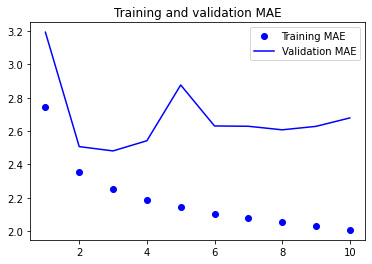

In [13]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 88s 106ms/step - loss: 23.1432 - mae: 3.7798 - val_loss: 18.3298 - val_mae: 3.4276
Epoch 2/10
819/819 [==============================] - 83s 101ms/step - loss: 15.8567 - mae: 3.1601 - val_loss: 16.3340 - val_mae: 3.1799
Epoch 3/10
819/819 [==============================] - 85s 103ms/step - loss: 14.4060 - mae: 3.0104 - val_loss: 15.8341 - val_mae: 3.1713
Epoch 4/10
819/819 [==============================] - 83s 101ms/step - loss: 13.5482 - mae: 2.9193 - val_loss: 14.9008 - val_mae: 3.0594
Epoch 5/10
819/819 [==============================] - 83s 101ms/step - loss: 12.9570 - mae: 2.8576 - val_loss: 16.0446 - val_mae: 3.1499
Epoch 6/10
819/819 [==============================] - 84s 102ms/step - loss: 12.4980 - mae: 2.8068 - val_loss: 17.4774 - val_mae: 3.2969
Epoch 7/10
819/819 [==============================] - 82s 100ms/step - loss: 12.0813 - mae: 2.7630 - val_loss: 15.2850 - val_mae: 3.0764
Epoch 8/10
819/819 [=====================

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 102s 122ms/step - loss: 40.6148 - mae: 4.6073 - val_loss: 11.9412 - val_mae: 2.6397
Epoch 2/10
819/819 [==============================] - 98s 120ms/step - loss: 10.8996 - mae: 2.5584 - val_loss: 9.8555 - val_mae: 2.4382
Epoch 3/10
819/819 [==============================] - 99s 121ms/step - loss: 9.7808 - mae: 2.4377 - val_loss: 10.1277 - val_mae: 2.4714
Epoch 4/10
819/819 [==============================] - 100s 122ms/step - loss: 9.3737 - mae: 2.3857 - val_loss: 9.7605 - val_mae: 2.4177
Epoch 5/10
819/819 [==============================] - 101s 123ms/step - loss: 9.0423 - mae: 2.3424 - val_loss: 9.8244 - val_mae: 2.4267
Epoch 6/10
819/819 [==============================] - 100s 122ms/step - loss: 8.7065 - mae: 2.3011 - val_loss: 10.0198 - val_mae: 2.4465
Epoch 7/10
819/819 [==============================] - 99s 120ms/step - loss: 8.3318 - mae: 2.2590 - val_loss: 10.3429 - val_mae: 2.4896
Epoch 8/10
819/819 [=========================

In [16]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [17]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [18]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [19]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [20]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 197s 237ms/step - loss: 26.9517 - mae: 3.8288 - val_loss: 9.8482 - val_mae: 2.4442
Epoch 2/10
819/819 [==============================] - 193s 235ms/step - loss: 14.8927 - mae: 2.9953 - val_loss: 9.3583 - val_mae: 2.3844
Epoch 3/10
819/819 [==============================] - 193s 235ms/step - loss: 13.9098 - mae: 2.8942 - val_loss: 9.7359 - val_mae: 2.4282
Epoch 4/10
819/819 [==============================] - 191s 233ms/step - loss: 13.2991 - mae: 2.8272 - val_loss: 9.5615 - val_mae: 2.4175
Epoch 5/10
819/819 [==============================] - 193s 236ms/step - loss: 12.7181 - mae: 2.7649 - val_loss: 10.0618 - val_mae: 2.4443
Epoch 6/10
819/819 [==============================] - 191s 233ms/step - loss: 12.4595 - mae: 2.7380 - val_loss: 9.5379 - val_mae: 2.4121
Epoch 7/10
819/819 [==============================] - 192s 234ms/step - loss: 12.1165 - mae: 2.6960 - val_loss: 9.6505 - val_mae: 2.4227
Epoch 8/10
819/819 [====================

In [22]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 330s 397ms/step - loss: 27.3668 - mae: 3.8299 - val_loss: 10.3112 - val_mae: 2.5008
Epoch 2/10
819/819 [==============================] - 327s 399ms/step - loss: 13.9369 - mae: 2.8904 - val_loss: 8.8322 - val_mae: 2.3022
Epoch 3/10
819/819 [==============================] - 330s 403ms/step - loss: 13.1821 - mae: 2.8131 - val_loss: 9.8129 - val_mae: 2.4519
Epoch 4/10
819/819 [==============================] - 332s 405ms/step - loss: 12.6116 - mae: 2.7549 - val_loss: 8.6313 - val_mae: 2.2764
Epoch 5/10
819/819 [==============================] - 328s 400ms/step - loss: 12.0848 - mae: 2.6987 - val_loss: 9.5665 - val_mae: 2.4183
Epoch 6/10
819/819 [==============================] - 326s 398ms/step - loss: 11.7525 - mae: 2.6613 - val_loss: 8.7622 - val_mae: 2.2986
Epoch 7/10
819/819 [==============================] - 326s 398ms/step - loss: 11.3347 - mae: 2.6169 - val_loss: 9.6902 - val_mae: 2.4300
Epoch 8/10
819/819 [====================

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 145s 172ms/step - loss: 26.0584 - mae: 3.6632 - val_loss: 10.6101 - val_mae: 2.5284
Epoch 2/10
819/819 [==============================] - 140s 171ms/step - loss: 9.3694 - mae: 2.3909 - val_loss: 9.8938 - val_mae: 2.4372
Epoch 3/10
819/819 [==============================] - 141s 172ms/step - loss: 8.4621 - mae: 2.2675 - val_loss: 9.5541 - val_mae: 2.3941
Epoch 4/10
819/819 [==============================] - 143s 174ms/step - loss: 7.8710 - mae: 2.1866 - val_loss: 9.9043 - val_mae: 2.4366
Epoch 5/10
819/819 [==============================] - 142s 173ms/step - loss: 7.4988 - mae: 2.1370 - val_loss: 10.1675 - val_mae: 2.4708
Epoch 6/10
819/819 [==============================] - 143s 174ms/step - loss: 7.2141 - mae: 2.0961 - val_loss: 10.1202 - val_mae: 2.4692
Epoch 7/10
819/819 [==============================] - 141s 172ms/step - loss: 6.9302 - mae: 2.0541 - val_loss: 10.6686 - val_mae: 2.5393
Epoch 8/10
819/819 [=======================